# Reading the datasets :

In [3]:
import pandas as pd
import numpy as np
from random import random
import matplotlib.pyplot as plt

df = pd.read_csv("./data/accounts.csv", sep=',')
dg = pd.read_csv("./data/posts.csv", sep=',')
dc = pd.read_csv("./data/posts2.csv", sep=',')

users= list(df['id_user'])

# Useful functions :

In [4]:
# id_followers_de(x) returns the list of the followers of x
def id_followers_de(x):
    e=list(df[df['id_user']==x]['id_followers'])
    L=[]
    i=1
    while e[0][i]!=']':
        
        S=''
        
        while e[0][i] in [' ', ',']:
            i+=1
        while e[0][i] in ['0','1','2','3','4','5','6','7','8','9']:
            S+=e[0][i]
            i+=1

        L.append(int(S))
        if e[0][i] in [' ', ',']:
            i+=1

    return L

followerss={x : id_followers_de(x) for x in users}


# post_posted_by(x) returns the [id_post , id_post_origin] of the posts (re)posted by x
def post_posted_by(x):
    L=[]
    a=list(dg[dg['id_user']==x]['id_post'])
    b=list(dg[dg['id_user']==x]['id_post_origin'])
    c=list(dc[dc['id_user']==x]['id_post'])
    d=list(dc[dc['id_user']==x]['id_post_origin'])
    if a:
        L.append(a+b)
    if c:
        L.append(c+d)
    return L


d={x: post_posted_by(x) for x in users}

In [5]:
def ratio1(x):
    L=post_posted_by(x)
    P=[]
    nbr_views=0
    nbr_followers=0
    b=list(df[df['id_user']==x]['nb_followers'])[0]
    for post in L:
        id=post[0]
        a=list(dg[dg['id_post']==id]['views'])
        c=list(dc[dc['id_post']==id]['views'])
        if a:
            nbr_views+=a[0]
            nbr_followers+=b
            
        if c:
            nbr_views+=c[0]
            nbr_followers+=b
        
        return min(nbr_views/nbr_followers,1)
    

def ratio2(x):
    L=post_posted_by(x)
    P=[]
    nbr_reposts=0
    nbr_followers=0
    b=list(df[df['id_user']==x]['nb_followers'])[0]
    for post in L:
        id=post[0]
        a=list(dg[dg['id_post']==id]['reposts'])
        c=list(dc[dc['id_post']==id]['reposts'])
        if a:
            nbr_reposts+=a[0]
            nbr_followers+=b
            
        if c:
            nbr_reposts+=c[0]
            nbr_followers+=b
            
        return nbr_reposts/nbr_followers

# The associaton of the probabilities to each user :

In [6]:
# the users
users=list(df['id_user'])
 
#dictionnary user: probability of a post (re)posted by x to be seen by a follower of x
Pv={x: ratio1(x) for x in users}

#dictionnary user : probability of a follower of x to repost a post of x
Pr={x: ratio2(x) for x in users}


In [11]:
def cout(F,k): # k influenceurs and F is the dictionary of convinced people:
    P=F[:k]
    c=0
    for user in P:
        c+=len(followerss[user])
    return c


def acc_views(L): # returns the number of accumulated views
    S=0
    for k,v in L.items():
        
        if v[0]:
            S+=Pv[k]*len(followerss[k])
    return S

# Ranking the influencers :

In [12]:
Pr_=[[k,v] for k,v in Pr.items()]
Pr_.sort(key=lambda x : x[1], reverse=True)
Pv_=[[k,v] for k,v in Pv.items()]
Pv_.sort(key=lambda x : x[1], reverse=True)

famous_people={}

for couple in Pr_:
    a,b=couple
    if b>0:
        famous_people[a]=b

for couple in Pv_:
    a,b=couple
    if Pr[a]==0:
        famous_people[a]=b
        
F=list(famous_people.keys())
print(F)

[587566, 672702, 884135, 537720, 306222, 483543, 861864, 925025, 848006, 866330, 466531, 623520, 697079, 474227, 428655, 695586, 817185, 208722, 637059, 776192, 141531, 746200, 196838, 711657, 335675, 387828, 363224, 573270, 281393, 680739, 895019, 945861, 589484, 485673, 257680, 561198, 775358, 715764, 993508, 517595, 863276, 286227, 457942, 115703, 134313, 575965, 803362, 280404, 596136, 360140, 469342, 523346, 581262, 451416, 410566, 741911, 369635, 755035, 898571, 341446, 764009, 761768, 208433, 922557, 922261, 781866, 290214, 784773, 529111, 516280, 585116, 561062, 265590, 291784, 552901, 386018, 454840, 229479, 650654, 581603, 811745, 929438, 876782, 882788, 635537, 758661, 906378, 262830, 360851, 606925, 629727, 656557, 428588, 530495, 695708, 620790, 973580, 426141, 969609, 530725, 684412, 738571, 531045, 813710, 613436, 872362, 165857, 850055, 579931, 122680, 363361, 839500, 980289, 158219, 506616, 706549, 630454, 926552, 391533, 924939, 704942, 283608, 206592, 427505, 394103,

# Analysis :

## The approach of small influencers : 

In [13]:
def main(kk):
    neutral={x: True for x in users}
    View={x: False for x in users}
    convinced={x: [False,0] for x in users}
    not_convinced={x: False for x in users}
    checked={x: False for x in users}
    influenced={}

    Vu={x: False for x in users}

###choose some influencers:
    Pppp = F[:kk]

    for i in Pppp:
        convinced[i][0]=True
        neutral[i]=False

    Vi=[0]
    Neut=[len(users)-len(Pppp)]
    Co=[len(Pppp)]
    Nco=[0]

    step=1
    limit=37
    while step<limit:
        for user in users:
            
            X=followerss[user]
            probr=Pv[user]
        
            if not checked[user]:
            
                if View[user]:
                    pppp=random()
                    View[user]=False
                    checked[user]=True
                
                ####
                    U=influenced[user]
                    pr=Pr[U]
                ###

                    if pppp<pr:
                        convinced[user][0]=True

                    else:
                        not_convinced[user]=True
                        
            if not checked[user]:
                if convinced[user][0] and convinced[user][1]<1:
                    convinced[user][1]+=1
                    checked[user]=True
                    for b in X :
                        if not convinced[b][0] and not checked[b]:
                            pppp=random()
                            if neutral[b] and pppp<probr:
                                neutral[b]=False
                                View[b]=True
                            
                            ####
                                influenced[b]=user
                            ###
                            
                                checked[b]=True
                    
                
        checked={x: False for x in users}
        
        Vi.append(len([1 for x in View if View[x]]))
        Neut.append(len([1 for x in neutral if neutral[x]]))
        Co.append(len([1 for x in convinced if convinced[x][0]]))
        Nco.append(len([1 for x in not_convinced if not_convinced[x]]))
        step+=1
                
    T=[i for i in range(limit)]
    Vu=[len(users)- y for y in Neut]
    return Vu[-1],Co[-1], convinced

Aaa=[ i for i in range(1,30)]
Bbb=[]#views
Ccc=[]#acc_v
Ddd=[]#convinced

S=0
n=0
Z=0
D=0
for k in range(29):
    print(k)
    for i in range(5):
        L=main(25)
        S+=L[0]
        #print(k)
        Z+=acc_views(L[2])
        D+=L[1]
        n+=1
    Bbb.append(S/n)
    Ccc.append(Z/n)
    Ddd.append(D/n)

plt.figure()
plt.plot(Aaa,Bbb)
plt.title("number of views")
plt.figure()
plt.plot(Aaa,Ccc)
plt.title("number of accumulated views")
plt.figure()
plt.plot(Aaa,Ddd)
plt.title("the number of convinced people")
plt.plot()
plt.show()

0
1
2
3
4
5
6
7
8
9
Unexpected exception formatting exception. Falling back to standard exception


Traceback (most recent call last):
  File "C:\Users\dell\AppData\Roaming\Python\Python311\site-packages\IPython\core\interactiveshell.py", line 3526, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "C:\Users\dell\AppData\Local\Temp\ipykernel_18496\3192155565.py", line 91, in <module>
    L=main(25)
      ^^^^^^^^
  File "C:\Users\dell\AppData\Local\Temp\ipykernel_18496\3192155565.py", line -1, in main
KeyboardInterrupt

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "C:\Users\dell\AppData\Roaming\Python\Python311\site-packages\IPython\core\interactiveshell.py", line 2120, in showtraceback
    stb = self.InteractiveTB.structured_traceback(
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\dell\AppData\Roaming\Python\Python311\site-packages\IPython\core\ultratb.py", line 1435, in structured_traceback
    return FormattedTB.structured_traceback(
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^

## The advertisement approach :

In [15]:
def main2(kk):
    neutral={x: True for x in users}
    View={x: False for x in users}
    convinced={x: [False,0] for x in users}
    not_convinced={x: False for x in users}
    checked={x: False for x in users}
    influenced={}

    Vu={x: False for x in users}

###choose some influencers:

    Pppp = F[:kk]
 

    for i in Pppp:
        View[i]=True
        neutral[i]=False

    Co=[0]
    Neut=[len(users)-len(Pppp)]
    Vi=[len(Pppp)]
    Nco=[0]
    step=1

    for user in users:
        if View[user]:
            View[user]=False
            pp=random()
            if pp < 0.01:
                convinced[user][0]=True
            else:
                not_convinced[user]=True

    checked={x: False for x in users}
        
    Vi.append(len([1 for x in View if View[x]]))
    Neut.append(len([1 for x in neutral if neutral[x]]))
    Co.append(len([1 for x in convinced if convinced[x][0]]))
    Nco.append(len([1 for x in not_convinced if not_convinced[x]]))

    
    step+=1
    limit=37
    while step<limit:
        for user in users:

            X=followerss[user]
            probr=Pv[user]

            if not checked[user]:
            
                if View[user]:
                    pppp=random()
                    View[user]=False
                    checked[user]=True
                
                ####
                    U=influenced[user]
                    pr=Pr[U]
                ###
                    if pppp<pr:
                        convinced[user][0]=True
                
                    else:
                        not_convinced[user]=True
                        
            if not checked[user]:
                if convinced[user][0] and convinced[user][1]<1:
                    convinced[user][1]+=1
                    checked[user]=True
                    for b in X :
                        if not convinced[b][0] and not checked[b]:
                            pppp=random()
                            if neutral[b] and pppp<probr:
                                neutral[b]=False
                                View[b]=True
                            
                            ####
                                influenced[b]=user
                            ###
                            
                                checked[b]=True
                    
                
        checked={x: False for x in users}
        
        Vi.append(len([1 for x in View if View[x]]))
        Neut.append(len([1 for x in neutral if neutral[x]]))
        Co.append(len([1 for x in convinced if convinced[x][0]]))
        Nco.append(len([1 for x in not_convinced if not_convinced[x]]))
        step+=1
                
    T=[i for i in range(limit)]
    Vu=[len(users)- y for y in Neut]
    return Vu[-1],Co[-1], convinced

Aaa=[ i for i in range(1,30)]
Bbb=[]#vu
Ccc=[]#acc_v
Ddd=[]#conv
S=0
n=0
Z=0
D=0
for k in range(29):
    print(k)
    for i in range(5):
        L=main2(1500)
        S+=L[0]
        #print(k)
        Z+=acc_views(L[2])
        D+=L[1]
        n+=1
    Bbb.append(S/n)
    Ccc.append(Z/n)
    Ddd.append(D/n)
plt.figure()
plt.plot(Aaa,Bbb)
plt.figure()
plt.plot(Aaa,Ccc)
plt.figure()
plt.plot(Aaa,Ddd)
plt.show()


0
1
2
3
4
5
6
7
Unexpected exception formatting exception. Falling back to standard exception


Traceback (most recent call last):
  File "C:\Users\dell\AppData\Roaming\Python\Python311\site-packages\IPython\core\interactiveshell.py", line 3526, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "C:\Users\dell\AppData\Local\Temp\ipykernel_18496\3179478376.py", line 109, in <module>
    L=main2(1500)
      ^^^^^^^^^^^
  File "C:\Users\dell\AppData\Local\Temp\ipykernel_18496\3179478376.py", line -1, in main2
KeyboardInterrupt

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "C:\Users\dell\AppData\Roaming\Python\Python311\site-packages\IPython\core\interactiveshell.py", line 2120, in showtraceback
    stb = self.InteractiveTB.structured_traceback(
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\dell\AppData\Roaming\Python\Python311\site-packages\IPython\core\ultratb.py", line 1435, in structured_traceback
    return FormattedTB.structured_traceback(
           ^^^^^^^^^^^^^^^^^^^

## The One big influencer approach


### Defining the updated graph

In [20]:

big_influencer_id = 1000000
followers = users[:2000]
changed_adjacence_list = followerss
changed_adjacence_list[big_influencer_id] = followers 
print(changed_adjacence_list)

{288877: [738818, 134147, 314454, 977416, 926730, 827404, 518670, 448535, 456218, 469532, 292893, 647710, 779810, 548443, 960092, 400938, 354867, 357942, 115262, 530495, 560706, 878659, 533064, 132535, 199756, 632402, 539662, 198230, 304727, 630873, 298587, 794716, 221283, 882788, 584296, 186382, 868467, 189557, 611446, 207479, 116344, 871035, 280700, 858239, 983681, 177794, 687041, 906378, 882827, 559763, 452244, 975000, 198852, 353434, 979100, 426141, 945861, 174242, 334502, 193703, 664234, 451246, 750257, 449395, 648884, 580126, 213181, 577312, 917186, 765124, 796357, 864969, 174110, 524492, 547779, 302805, 257239, 765145, 854238, 386427, 702180, 596716, 613101, 158451, 245427, 620790, 300279, 654072, 202794, 291078, 498952, 788238, 352017, 157458, 462105, 399645, 419103, 277792, 953643, 446254, 727348, 303413, 580747, 839500, 208722, 695385, 903514, 363361, 526691, 579947, 894828, 794990, 951664, 662899, 139124, 919415, 873338, 201595, 927980, 510860, 616845, 792301, 759900, 444307

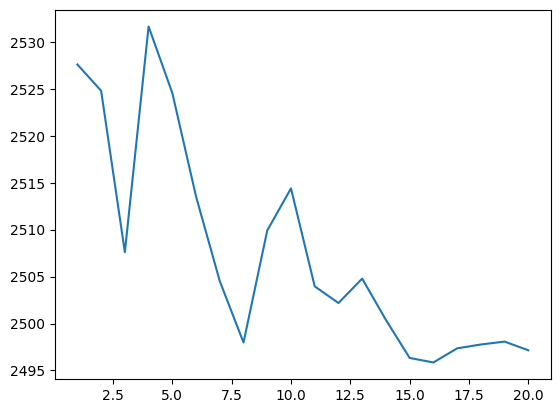

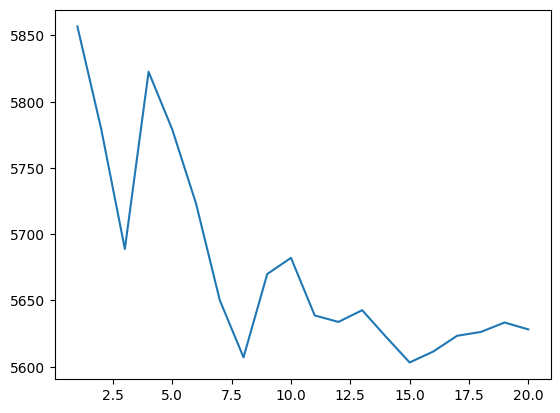

In [21]:


from random import random
import matplotlib.pyplot  as plt
def main():
    neutral={x: True for x in changed_adjacence_list}
    View={x: False for x in changed_adjacence_list}
    Acc_views={x:0 for x in changed_adjacence_list} ####
    convinced={x: [False,0] for x in changed_adjacence_list}
    not_convinced={x: False for x in changed_adjacence_list}
    checked={x: False for x in changed_adjacence_list}
    influenced={}
    viewed_by={x:{y: False for y in changed_adjacence_list} for x in changed_adjacence_list} ####


    Pppp = [big_influencer_id]
    
    for i in Pppp:
        convinced[i][0]=True
        neutral[i]=False
    pv=0.25
    pr=0.1
    Vi=[0]
    Neut=[len(users)-len(Pppp)]
    Co=[len(Pppp)]
    Nco=[0]

    step=1
    limit=37
    while step<limit:
        for user in changed_adjacence_list:
            
            
            X=changed_adjacence_list[user]
            
            if user ==big_influencer_id:
                probr=pv
            else: probr=Pv[user]
        
            if not checked[user]:
                if View[user]:
                    pppp=random()
                    View[user]=False
                    checked[user]=True
                
                    U=influenced[user]
                    
                    
                
                    if U == big_influencer_id and pppp < pr:
                            convinced[user][0]=True
                    elif U != big_influencer_id and pppp < Pr[U]:
                            convinced[user][0]=True
                    else:
                        not_convinced[user]=True
        
            if not checked[user] :
                if convinced[user][0] and convinced[user][1]<1:
                    convinced[user][1]+=1
                    checked[user]=True
                    for b in X :
                        if not convinced[b][0] and not checked[b]:
                            pppp=random()
                            if neutral[b] and pppp<probr:
                                
                                neutral[b]=False
                                View[b]=True
                                Acc_views[b]+=1
                                viewed_by[b][user]= True
                                influenced[b]=user
                                checked[b]=True
                        
                        if not viewed_by[b][user] :
                            www=random()
                            if www<probr:
                                Acc_views[b]+=1
                                viewed_by[b][user]=True
                                influenced[b]=user
                                checked[b]=True
                    
        
        checked={x: False for x in changed_adjacence_list}
        
        Vi.append(len([1 for x in View if View[x]]))
        Neut.append(len([1 for x in neutral if neutral[x]]))
        Co.append(len([1 for x in convinced if convinced[x][0]]))
        Nco.append(len([1 for x in not_convinced if not_convinced[x]]))
        step+=1
    T=[i for i in range(limit)]
    Vu=[len(users)- y for y in Neut]

    def acc_views(L):
        S=0
        for k,v in L.items():
            if v[0]:
                if k == big_influencer_id:
                    S+=pv*len(changed_adjacence_list[k])
                else: 
                    S+=Pv[k]*len(changed_adjacence_list[k])
        return S
    return Vu[-1],acc_views(convinced)
   
Aaa=[ i for i in range(1,21)]
Bbb=[]
Ccc=[]
S=0
n=0
Ss=0
for k in range(20):
    for i in range(5):
        O=main()
        S+=O[0]
        Ss+=O[1]
        n+=1
    Bbb.append(S/n)
    Ccc.append(Ss/n)

plt.figure()
plt.plot(Aaa,Bbb)
plt.figure()
plt.plot(Aaa,Ccc)
plt.show()
